---
title: "Escaping the devil's funnel: centered and non-centered priors"
mathjax: True
toc: true
toc_sticky: true
categories: [data science, statistics]
---

Multi-level models are great for improving our estimates. However, the intuitive way these kinds of models are specified (which goes by the [unhelpful](https://media.giphy.com/media/LS4AuDMMDZaUJJcusY/giphy.gif) name "centered" parameterization) can be [notorious](https://media.giphy.com/media/AsDBIwyLjHc9G/giphy.gif) for producing posterior distributions that are difficult to sample using Markov chain Monte Carlo. This is because when parameters (such as the scale variable of one distribution) depends on other parameters, the posterior can have weird shapes. This is the rationale for re-specifying the model into a ["non-centered" parameterization](https://benslack19.github.io/data%20science/statistics/diagnosing-a-model/#me-attempt-4-re-paramaterization).

In an online discussion forum, we shared experiences with these kinds of parameterizations since it was around the same time [lecture 13 of Statistical Rethinking](https://www.youtube.com/watch?v=n2aJYtuGu54&list=PLDcUM9US4XdMROZ57-OIRtIK0aOynbgZN&index=13) was released. I had always thought to start with a centered parameterization (since it's easier for me to understand) but if sampling is poor, switch to non-centered form. However, Matt said that non-centered does not always sample more efficiently for him. Lime chimed in that "rule of thumb is that centered parameterization works better when you have an informative likelihood, and noncentered is better when you have an informative prior." This led to additional comments from Jan about thought experiments.

I thought about how manipulating priors, the number of clusters, and the amount of data per cluster might be able to tell us something about sampling between centered parameterization to a non-centered parameterizations. Specifically, I thought there would be points of different models and datasets where the sampling efficiency switches from being better with a centered parameterization to a non-centered parameterization.

Let's see if this really happens! (Spoiler alert: It's not as clear cut as I would have thought.)

In [1]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc3 as pm
import scipy.stats as stats
from scipy.special import expit
from scipy.special import logit
import seaborn as sns
import statsmodels.api as sm

In [2]:
%load_ext nb_black
%config InlineBackend.figure_format = 'retina'
%load_ext watermark
RANDOM_SEED = 8927
np.random.seed(RANDOM_SEED)
az.style.use("arviz-darkgrid")
az.rcParams["stats.hdi_prob"] = 0.89  # sets default credible interval used by arviz

<IPython.core.display.Javascript object>

In [3]:
def standardize(x):
    x = (x - np.mean(x)) / np.std(x)
    return x

<IPython.core.display.Javascript object>

# Devil's Funnel example

Since I just watched the [divergent transition section](https://www.youtube.com/watch?v=n2aJYtuGu54&list=PLDcUM9US4XdMROZ57-OIRtIK0aOynbgZN&index=13&t=2319s) of the lecture, I thought my experiments could start here. Dr. McElreath presents "the devil's funnel" as an example to illustrate this. The variables were originally specified like this:

$$ \nu \sim \text{Normal}(0, 3) $$
$$ x \sim \text{Normal}(0, \text{exp}(\nu)) $$

The funnel gets more extreme with higher values for the standard deviation of $\nu$. Since there is no data here, this would be like manipulating priors only. I therefore experimented with different values for the standard deviation (sigma) of $\nu$.

In [730]:
# Generate a list of sigmas for the prior nu
sigmas = np.geomspace(0.025, 1, num=10)

# Create dictionaries for storage
# samples for plotting
traces_C = dict()
traces_NC = dict()

# summary results
summary_C = dict()
summary_NC = dict()

# number of divergences
div_C = dict()
div_NC = dict()

<IPython.core.display.Javascript object>

In [307]:
# Look at sigma values
sigmas

array([0.025     , 0.03766575, 0.05674836, 0.0854988 , 0.12881507,
       0.19407667, 0.29240177, 0.44054134, 0.66373288, 1.        ])

<IPython.core.display.Javascript object>

The following code evaluates each sigma value and uses that to build centered and non-centered models. I'll save the results at the end of each model run and then plot the sampling metrics down below.

In [737]:
for sigma in sigmas:

    # Centered model
    with pm.Model() as mC:
        v = pm.Normal("v", 0.0, sigma)
        x = pm.Normal("x", 0.0, pm.math.exp(v))
        trace_mC = pm.sample(draws=1000, tune=1000, chains=4, return_inferencedata=False, progressbar=False)
        # Save results
        traces_C[sigma] = trace_mC
        summary_C[sigma] = az.summary(trace_mC)
        div_C[sigma] = trace_mC["diverging"].sum()

    # Non-centered model
    with pm.Model() as mNC:
        v = pm.Normal("v", 0.0, sigma)
        z = pm.Normal("z", 0.0, 1.0)
        # transformed variable
        x = pm.Deterministic("x", z*np.exp(v))
        trace_mNC = pm.sample(draws=1000, tune=1000, chains=4, return_inferencedata=False, progressbar=False)

        # Save results
        traces_NC[sigma] = trace_mNC
        summary_NC[sigma] = az.summary(trace_mNC)
        div_NC[sigma]= trace_mNC["diverging"].sum()

Auto-assigning NUTS sampler...
INFO:pymc3:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO:pymc3:Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
INFO:pymc3:Multiprocess sampling (4 chains in 4 jobs)
NUTS: [x, v]
INFO:pymc3:NUTS: [x, v]
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 21 seconds.
INFO:pymc3:Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 21 seconds.
Auto-assigning NUTS sampler...
INFO:pymc3:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO:pymc3:Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
INFO:pymc3:Multiprocess sampling (4 chains in 4 jobs)
NUTS: [z, v]
INFO:pymc3:NUTS: [z, v]
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 18 seconds.
INFO:pymc3:Sampling 4 chains for 1_000 tune and 1_000 draw it

<IPython.core.display.Javascript object>

## Exploration of the joint distribution

<ipython-input-748-9c60ee011cae>:28: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 
  plt.tight_layout()


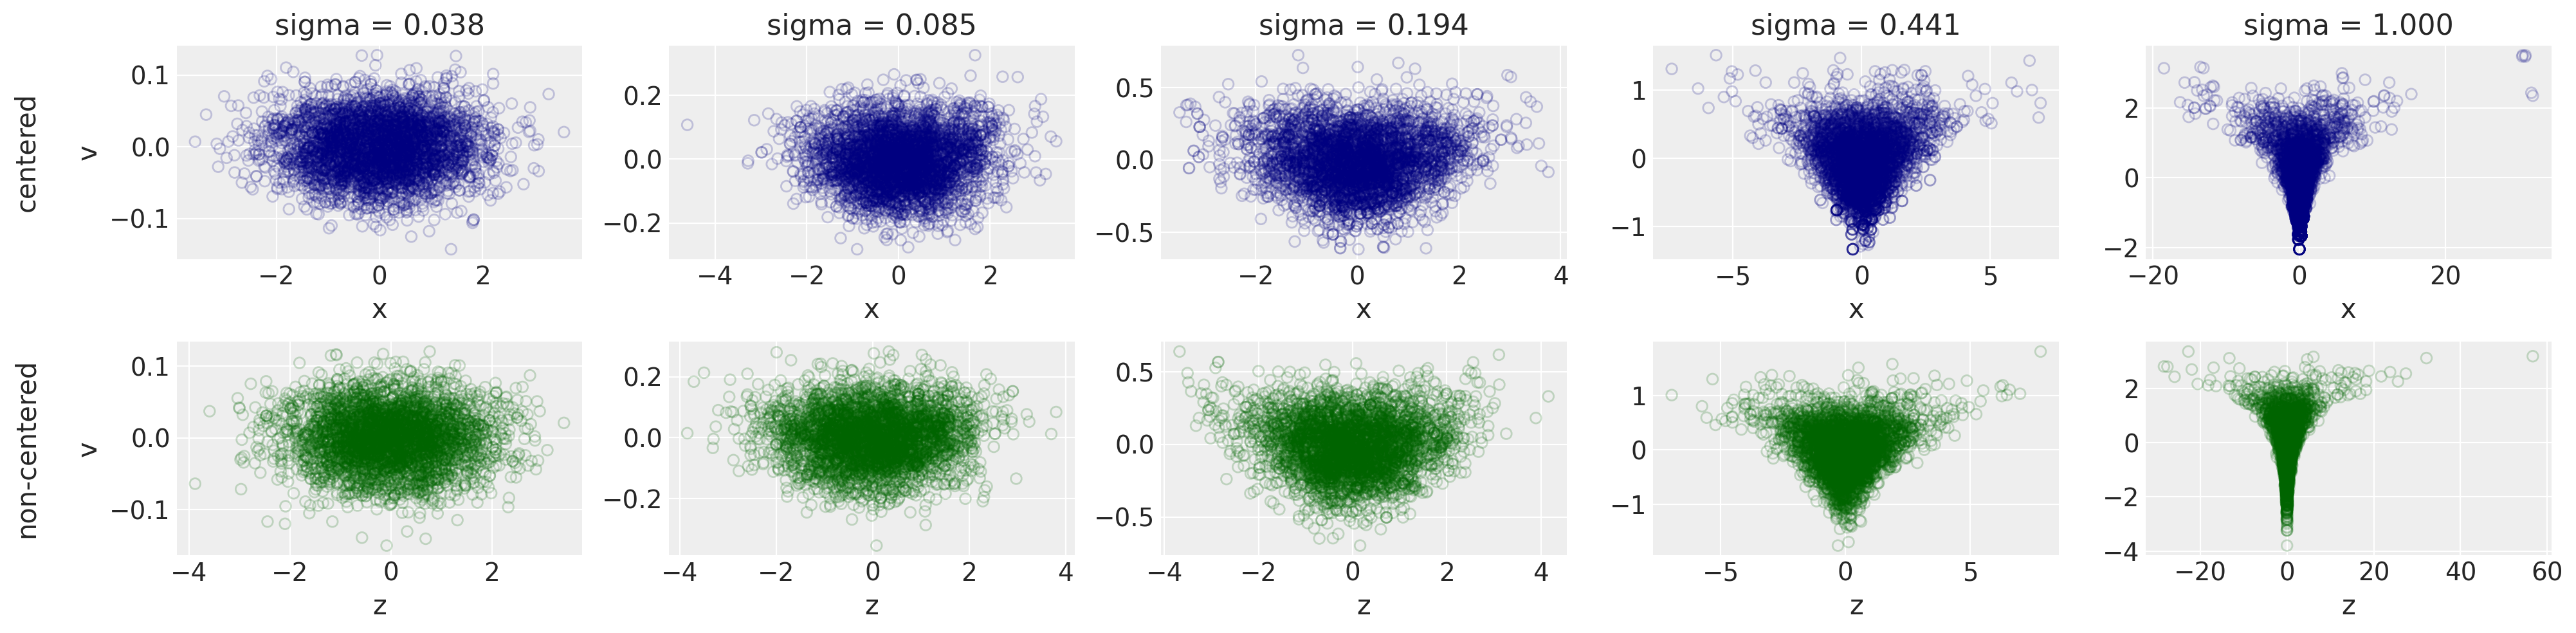

<IPython.core.display.Javascript object>

In [748]:
f, axes = plt.subplots(2, int(len(sigmas)/2), figsize=(20, 5))

for sigma, ax in zip(sigmas[1:len(sigmas):2], axes.flat):

    samples_C = pm.trace_to_dataframe(traces_C[sigma])
    ax.scatter(samples_C['x'], samples_C['v'], alpha=0.2, facecolors='none', edgecolors='navy')
    # number of divergences don't seem to match plot
    # bool_div_c = trace_mC['diverging']
    # ax.scatter(samples_C.loc[bool_div_c, 'x'], samples_C.loc[bool_div_c, 'v'], alpha=0.2, facecolors='red', s=2**2)

    sigma_str = '{:.3f}'.format(sigma)
    ax.set_title(f'sigma = {sigma_str}')
    ax.set_xlabel('x')
    if ax.is_first_col() & ax.is_first_row():
        ax.set_ylabel('centered\n\nv')

for sigma, ax in zip(sigmas[1:len(sigmas):2], axes.flat[int(len(sigmas)/2):len(sigmas)]):
    samples_NC = pm.trace_to_dataframe(traces_NC[sigma])
    #ax.scatter(samples_NC['z'], samples_NC['v'], alpha=0.2, facecolors='none', edgecolors='darkgreen')
    ax.scatter(samples_NC['x'], samples_NC['v'], alpha=0.2, facecolors='none', edgecolors='darkgreen')
    # bool_div_nc = trace_mNC['diverging']
    # ax.scatter(samples_NC.loc[bool_div_nc, 'z'], samples_NC.loc[bool_div_nc, 'v'], alpha=0.2, facecolors='red', s=2**2)

    ax.set_xlabel('z')
    if ax.is_first_col() & ax.is_last_row():
        ax.set_ylabel('non-centered\n\nv')
        
plt.tight_layout()

## Number of divergences

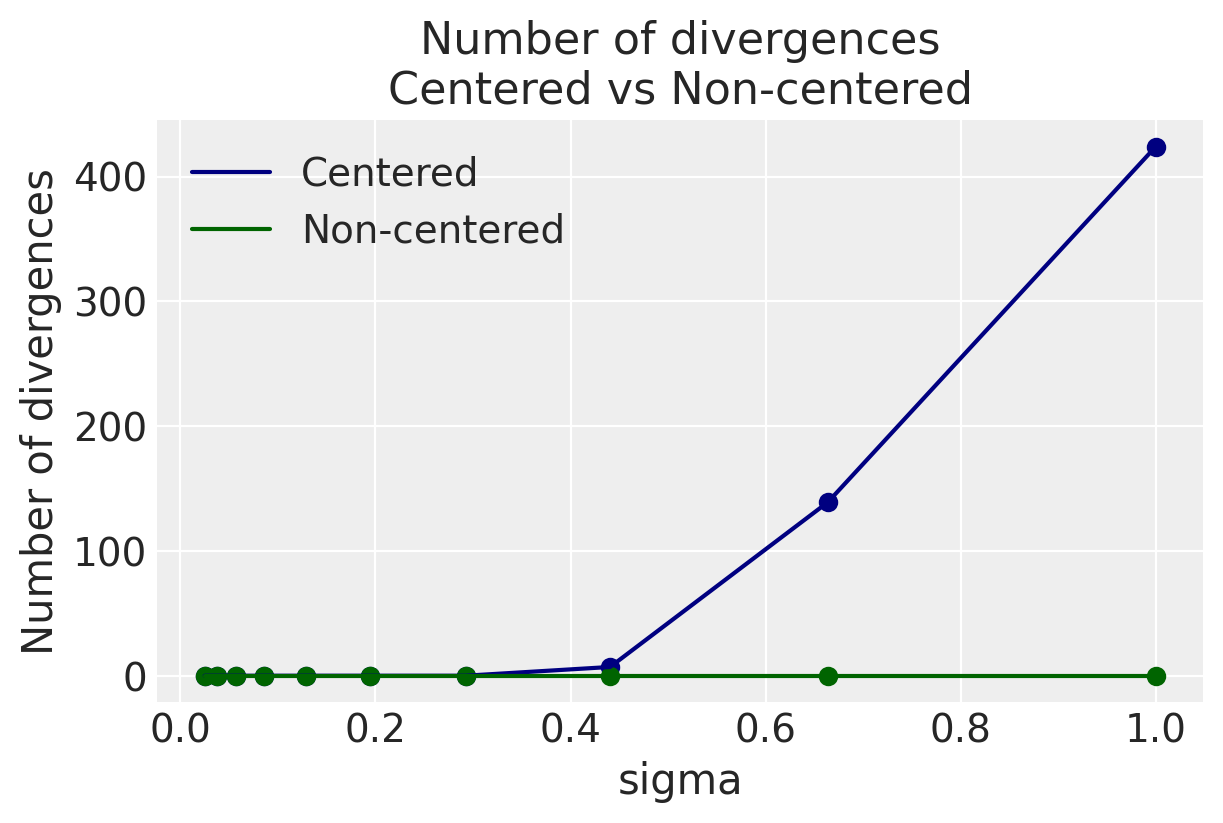

<IPython.core.display.Javascript object>

In [749]:
f, ax1 = plt.subplots(figsize=(6, 4))
ax1.scatter(div_C.keys(), div_C.values(), color='navy')
ax1.plot(div_C.keys(), div_C.values(), color='navy', label='Centered')
ax1.scatter(div_NC.keys(), div_NC.values(), color='darkgreen')
ax1.plot(div_NC.keys(), div_NC.values(), color='darkgreen', label='Non-centered')
ax1.set(xlabel='sigma', ylabel='Number of divergences', title='Number of divergences\nCentered vs Non-centered')
ax1.legend()

## Number of effective samples and R-hat

In [750]:
# Put the summary results in one table to facilitate plotting
df_summary_C = pd.concat(pd.DataFrame(summary_C[sigma]).reset_index().rename(columns={'index': 'var'}) for sigma in sigmas).reset_index(drop=True)
df_summary_C['sigma'] = sorted(list(sigmas)*2)

df_summary_NC = pd.concat(pd.DataFrame(summary_NC[sigma]).reset_index().rename(columns={'index': 'var'}) for sigma in sigmas).reset_index(drop=True)
df_summary_NC['sigma'] = sorted(list(sigmas)*3)

<IPython.core.display.Javascript object>

[Text(0.5, 0, 'sigma'),
 Text(0, 0.5, 'R-hat'),
 None,
 Text(0.5, 1.0, 'R-hat for x')]

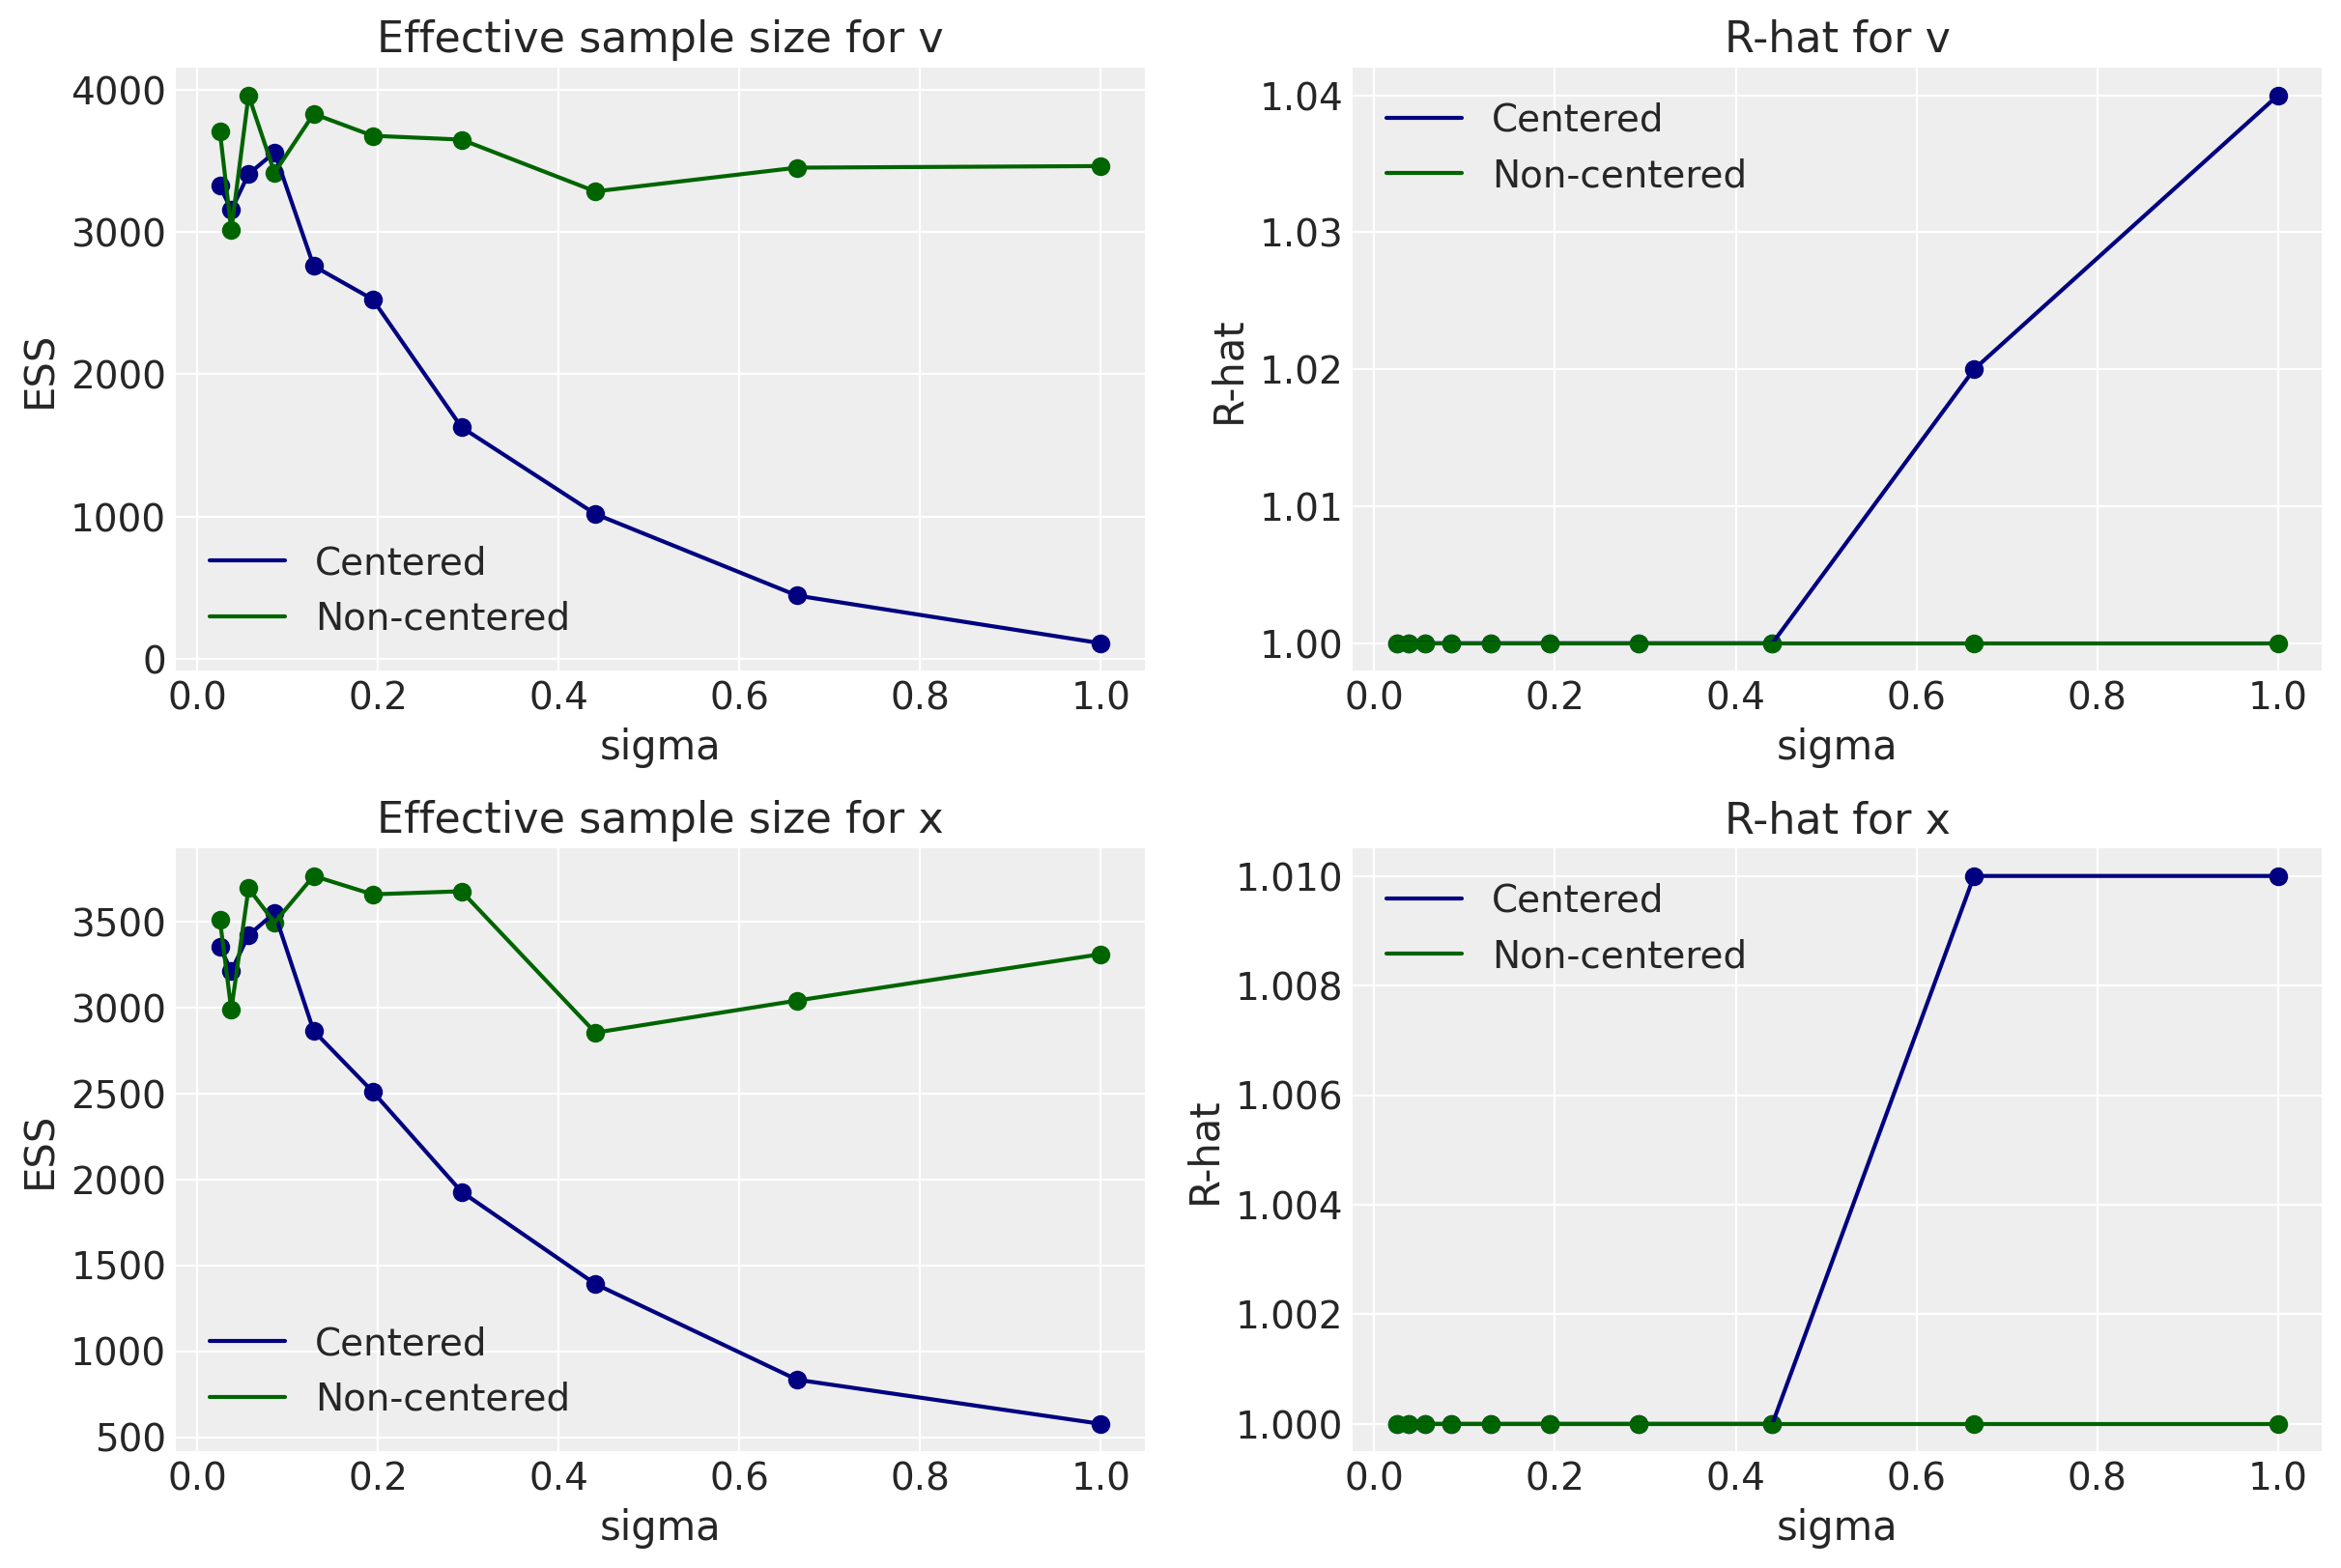

<IPython.core.display.Javascript object>

In [751]:
f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(12, 8))

# Top row (v) ---------

# plot centered ESS
df_centered_v = df_summary_C.loc[df_summary_C['var']=='v', :]
ax1.scatter(df_centered_v['sigma'], df_centered_v['ess_mean'], color='navy')
ax1.plot(df_centered_v['sigma'], df_centered_v['ess_mean'], color='navy', label='Centered')

ax2.scatter(df_centered_v['sigma'], df_centered_v['r_hat'], color='navy')
ax2.plot(df_centered_v['sigma'], df_centered_v['r_hat'], color='navy', label='Centered')

# plot non-centered ESS
df_noncentered_v = df_summary_NC.loc[df_summary_NC['var']=='v', :]
ax1.scatter(df_noncentered_v['sigma'], df_noncentered_v['ess_mean'], color='darkgreen')
ax1.plot(df_noncentered_v['sigma'], df_noncentered_v['ess_mean'], color='darkgreen', label='Non-centered')

ax2.scatter(df_noncentered_v['sigma'], df_noncentered_v['r_hat'], color='darkgreen')
ax2.plot(df_noncentered_v['sigma'], df_noncentered_v['r_hat'], color='darkgreen', label='Non-centered')

# plot decorations
ax1.legend()
ax1.set(xlabel='sigma', ylabel='ESS', xscale='linear', title='Effective sample size for v')

ax2.legend()
ax2.set(xlabel='sigma', ylabel='R-hat', xscale='linear', title='R-hat for v')

# Bottom row (x) ---------

# plot centered ESS
df_centered_x = df_summary_C.loc[df_summary_C['var']=='x', :]
ax3.scatter(df_centered_x['sigma'], df_centered_x['ess_mean'], color='navy')
ax3.plot(df_centered_x['sigma'], df_centered_x['ess_mean'], color='navy', label='Centered')

ax4.scatter(df_centered_x['sigma'], df_centered_x['r_hat'], color='navy')
ax4.plot(df_centered_x['sigma'], df_centered_x['r_hat'], color='navy', label='Centered')

# plot non-centered ESS
df_noncentered_x = df_summary_NC.loc[df_summary_NC['var']=='x', :]
ax3.scatter(df_noncentered_x['sigma'], df_noncentered_x['ess_mean'], color='darkgreen')
ax3.plot(df_noncentered_x['sigma'], df_noncentered_x['ess_mean'], color='darkgreen', label='Non-centered')

ax4.scatter(df_noncentered_x['sigma'], df_noncentered_x['r_hat'], color='darkgreen')
ax4.plot(df_noncentered_x['sigma'], df_noncentered_x['r_hat'], color='darkgreen', label='Non-centered')

# plot decorations
ax3.legend()
ax3.set(xlabel='sigma', ylabel='ESS', xscale='linear', title='Effective sample size for x')

ax4.legend()
ax4.set(xlabel='sigma', ylabel='R-hat', xscale='linear', title='R-hat for x')



When looking at the number of divergences, effective sample size, and R-hat, smaller values of sigma result in good sampling whether it's in the centered or non-centered form of the Devil's Funnel equations. However, between 0.2 and 0.4, we begin to see indications that the non-centered form is clearly doing better.

# Bangladesh data

The Devil's Funnel is a nice and simple example of how changing priors can affect sampling. But to assess the impactd of likelihoods, we would need to have data. I used the "Bangladesh" dataset, which is also described in Statistical Rethinking. I also used this dataset in a [previous multilevel model post](https://benslack19.github.io/data%20science/statistics/multilevel_modeling_01/).

In [4]:
DATA_DIR = '/Users/blacar/Documents/ds_projects/stats_rethinking/pymc3_ed_resources/resources/Rethinking_2/End_of_chapter_problems/data/'
df_bangladesh = pd.read_csv(DATA_DIR + "bangladesh.csv", sep=";", header=0)
# Encode the district variable
df_bangladesh["district_code"] = pd.Categorical(df_bangladesh["district"]).codes
df_bangladesh.head()

woman  district  use.contraception  living.children  age.centered  urban  \
0      1         1                  0                4       18.4400      1   
1      2         1                  0                1       -5.5599      1   
2      3         1                  0                3        1.4400      1   
3      4         1                  0                4        8.4400      1   
4      5         1                  0                1      -13.5590      1   

   district_code  
0              0  
1              0  
2              0  
3              0  
4              0

<IPython.core.display.Javascript object>

Here I'm now varying three factors that I thought would impact sampling in centered and non-centered versions of the model:
- the prior
- the number of clusters (districts)
- amount of data per cluster (number of women)

In [5]:
# Generate a list of lambdas for the prior nu
sds = np.geomspace(0.025, 1, num=5)

# Generate a list for number of districts to sample
n_districts = np.arange(3, 21, 3)

# Generate fraction of data to sample in each district
f_data = [0.1, 0.25, 0.5, 1]

# Create variables storage
# samples for plotting
traces_C = dict()
traces_NC = dict()

# list for storing divergence series
div_C_list = list()
div_NC_list = list()

# list for storing summary dfs
summary_C_list = list()
summary_NC_list = list()

<IPython.core.display.Javascript object>

In [6]:
print("lambda parameters to test: ", sds)

print("number of districts to test: ", n_districts)

print("fraction of data from each district to test: ", f_data)

lambda parameters to test:  [0.025      0.06287167 0.15811388 0.39763536 1.        ]
number of districts to test:  [ 3  6  9 12 15 18]
fraction of data from each district to test:  [0.1, 0.25, 0.5, 1]


<IPython.core.display.Javascript object>

Since the dataset has districts that vary in the number of women, I filtered the data so that they have the same starting amount (between 10 and 20).

In [7]:
# shown in descending order of number of women in the district
dist2keep = df_bangladesh['district'].value_counts()[((df_bangladesh['district'].value_counts() > 10) & (df_bangladesh['district'].value_counts() <= 20))].index
dist2keep

Int64Index([16, 2, 22, 50, 53, 21, 7, 36, 20, 47, 23, 24, 38, 33, 26, 10, 37,
            42],
           dtype='int64')

<IPython.core.display.Javascript object>

The following code then shows three loops, one for each factor I'm trying to manipulate, before building centered and non-centered models as I did above. I store the results so that I can plot them down below.

In [8]:
# Change how informative prior is
for sd in sds:

    # Change number of districts to sample)
    for n_district in n_districts:

        # Change amount of data from each district
        for fr in f_data:

            # Reduce number of clusters
            df_bangladesh_n = df_bangladesh[df_bangladesh['district'].isin(dist2keep[0:n_district])]

            # Reduce amount of data from each district
            df_bangladesh_n = df_bangladesh_n.groupby('district').sample(frac=fr, random_state=19)

            # Update the encoding of the district variable
            df_bangladesh_n["district_code2"] = pd.Categorical(df_bangladesh_n["district"]).codes

            # Centered model
            with pm.Model() as mBc:

                # prior for average district
                a_bar = pm.Normal("a_bar", 0.0, 1.5)

                # prior for SD of districts
                sigma = pm.Exponential("sigma", sd)    # < --- changing in each outer loop

                # alpha prior
                a = pm.Normal("a", a_bar, sigma, shape=len(df_bangladesh_n["district_code2"].unique()))

                # link function
                p = pm.math.invlogit(a[df_bangladesh_n["district_code2"]])

                # likelihood, n=1 since each represents an individual woman
                c = pm.Binomial("c", n=1, p=p, observed=df_bangladesh_n["use.contraception"])

                trace_mBc = pm.sample(draws=1000, random_seed=19, return_inferencedata=False, progressbar=False)

                # Store results
                traces_C[f's{sd}d{n_district}f{fr}'] = trace_mBc

                div_C = pd.Series(
                    {
                        'n_div' : trace_mBc["diverging"].sum(),
                        'n_districts' : n_district,
                        'lamb' : sd,
                        'f_data' : fr
                        }
                        )
                div_C_list.append(div_C)

                df_summary_c = az.summary(trace_mBc)
                df_summary_c['n_districts'], df_summary_c['lamb'], df_summary_c['f_data'] = n_district, sd, fr
                summary_C_list.append(df_summary_c)

            # Non-centered model
            with pm.Model() as mBnc:

                # prior for average district
                a_bar = pm.Normal("a_bar", 0.0, 1.5)
                # prior for SD of districts
                sigma = pm.Exponential("sigma", sd)   # < --- changing in each outer loop

                # z as a substitute for alpha prior
                z = pm.Normal("z", 0.0, 1, shape=len(df_bangladesh_n["district_code2"].unique()))

                # new link function
                p = pm.math.invlogit(a_bar + z[df_bangladesh_n["district_code2"]] * sigma)

                # likelihood, n=1 since each represents an individual woman
                c = pm.Binomial("c", n=1, p=p, observed=df_bangladesh_n["use.contraception"])

                trace_mBnc = pm.sample(draws=1000, random_seed=19, return_inferencedata=False, progressbar=False)

                # Store results
                traces_NC[f's{sd}d{n_district}f{fr}'] = trace_mBnc

                div_NC = pd.Series(
                    {
                        'n_div' : trace_mBnc["diverging"].sum(),
                        'n_districts' : n_district,
                        'lamb' : sd,
                        'f_data' : fr
                        }
                        )
                div_NC_list.append(div_NC)

                df_summary_nc = az.summary(trace_mBnc)
                df_summary_nc['n_districts'], df_summary_nc['lamb'], df_summary_nc['f_data'] = n_district, sd, fr
                summary_NC_list.append(df_summary_nc)

            

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, sigma, a_bar]
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 26 seconds.
There were 6 divergences after tuning. Increase `target_accept` or reparameterize.
There were 26 divergences after tuning. Increase `target_accept` or reparameterize.
There were 25 divergences after tuning. Increase `target_accept` or reparameterize.
There were 53 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [z, sigma, a_bar]
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws tota

<IPython.core.display.Javascript object>

I then combine the results into dataframes. I show a preview of the centered versions of the divergences table and the summary statistics table.

In [9]:
df_div_C = pd.DataFrame(div_C_list)
df_div_NC = pd.DataFrame(div_NC_list)
df_div_C.head()

n_div  n_districts   lamb  f_data
0  110.0          3.0  0.025    0.10
1  206.0          3.0  0.025    0.25
2  262.0          3.0  0.025    0.50
3  271.0          3.0  0.025    1.00
4  154.0          6.0  0.025    0.10

<IPython.core.display.Javascript object>

In [10]:
df_summary_C = pd.concat(summary_C_list).reset_index().rename({'index':'var'}, axis=1)
df_summary_NC = pd.concat(summary_NC_list).reset_index().rename({'index':'var'}, axis=1)
df_summary_C.head()

var    mean      sd  hdi_5.5%  hdi_94.5%  mcse_mean  mcse_sd  ess_mean  \
0  a_bar  -0.012   1.429    -2.199      2.230      0.046    0.033     950.0   
1   a[0]  -0.066   1.804    -2.795      2.877      0.068    0.057     700.0   
2   a[1] -14.102  23.131   -30.611      1.717      2.352    1.668      97.0   
3   a[2]  14.276  23.096    -1.554     31.043      2.217    1.572     109.0   
4  sigma  17.594  21.358     1.075     39.013      2.570    1.825      69.0   

   ess_sd  ess_bulk  ess_tail  r_hat  n_districts   lamb  f_data  
0   950.0     943.0    1483.0   1.00            3  0.025     0.1  
1   496.0     754.0     635.0   1.01            3  0.025     0.1  
2    97.0     139.0     130.0   1.03            3  0.025     0.1  
3   109.0      82.0     144.0   1.04            3  0.025     0.1  
4    69.0      44.0      63.0   1.07            3  0.025     0.1

<IPython.core.display.Javascript object>

## Number of divergences

The next set of code is a way to plot the divergences results together. It's a lot of code but most of it is plot decoration. 

Text(0.5, 0.98, 'Number of divergences with changing prior and likelihood')

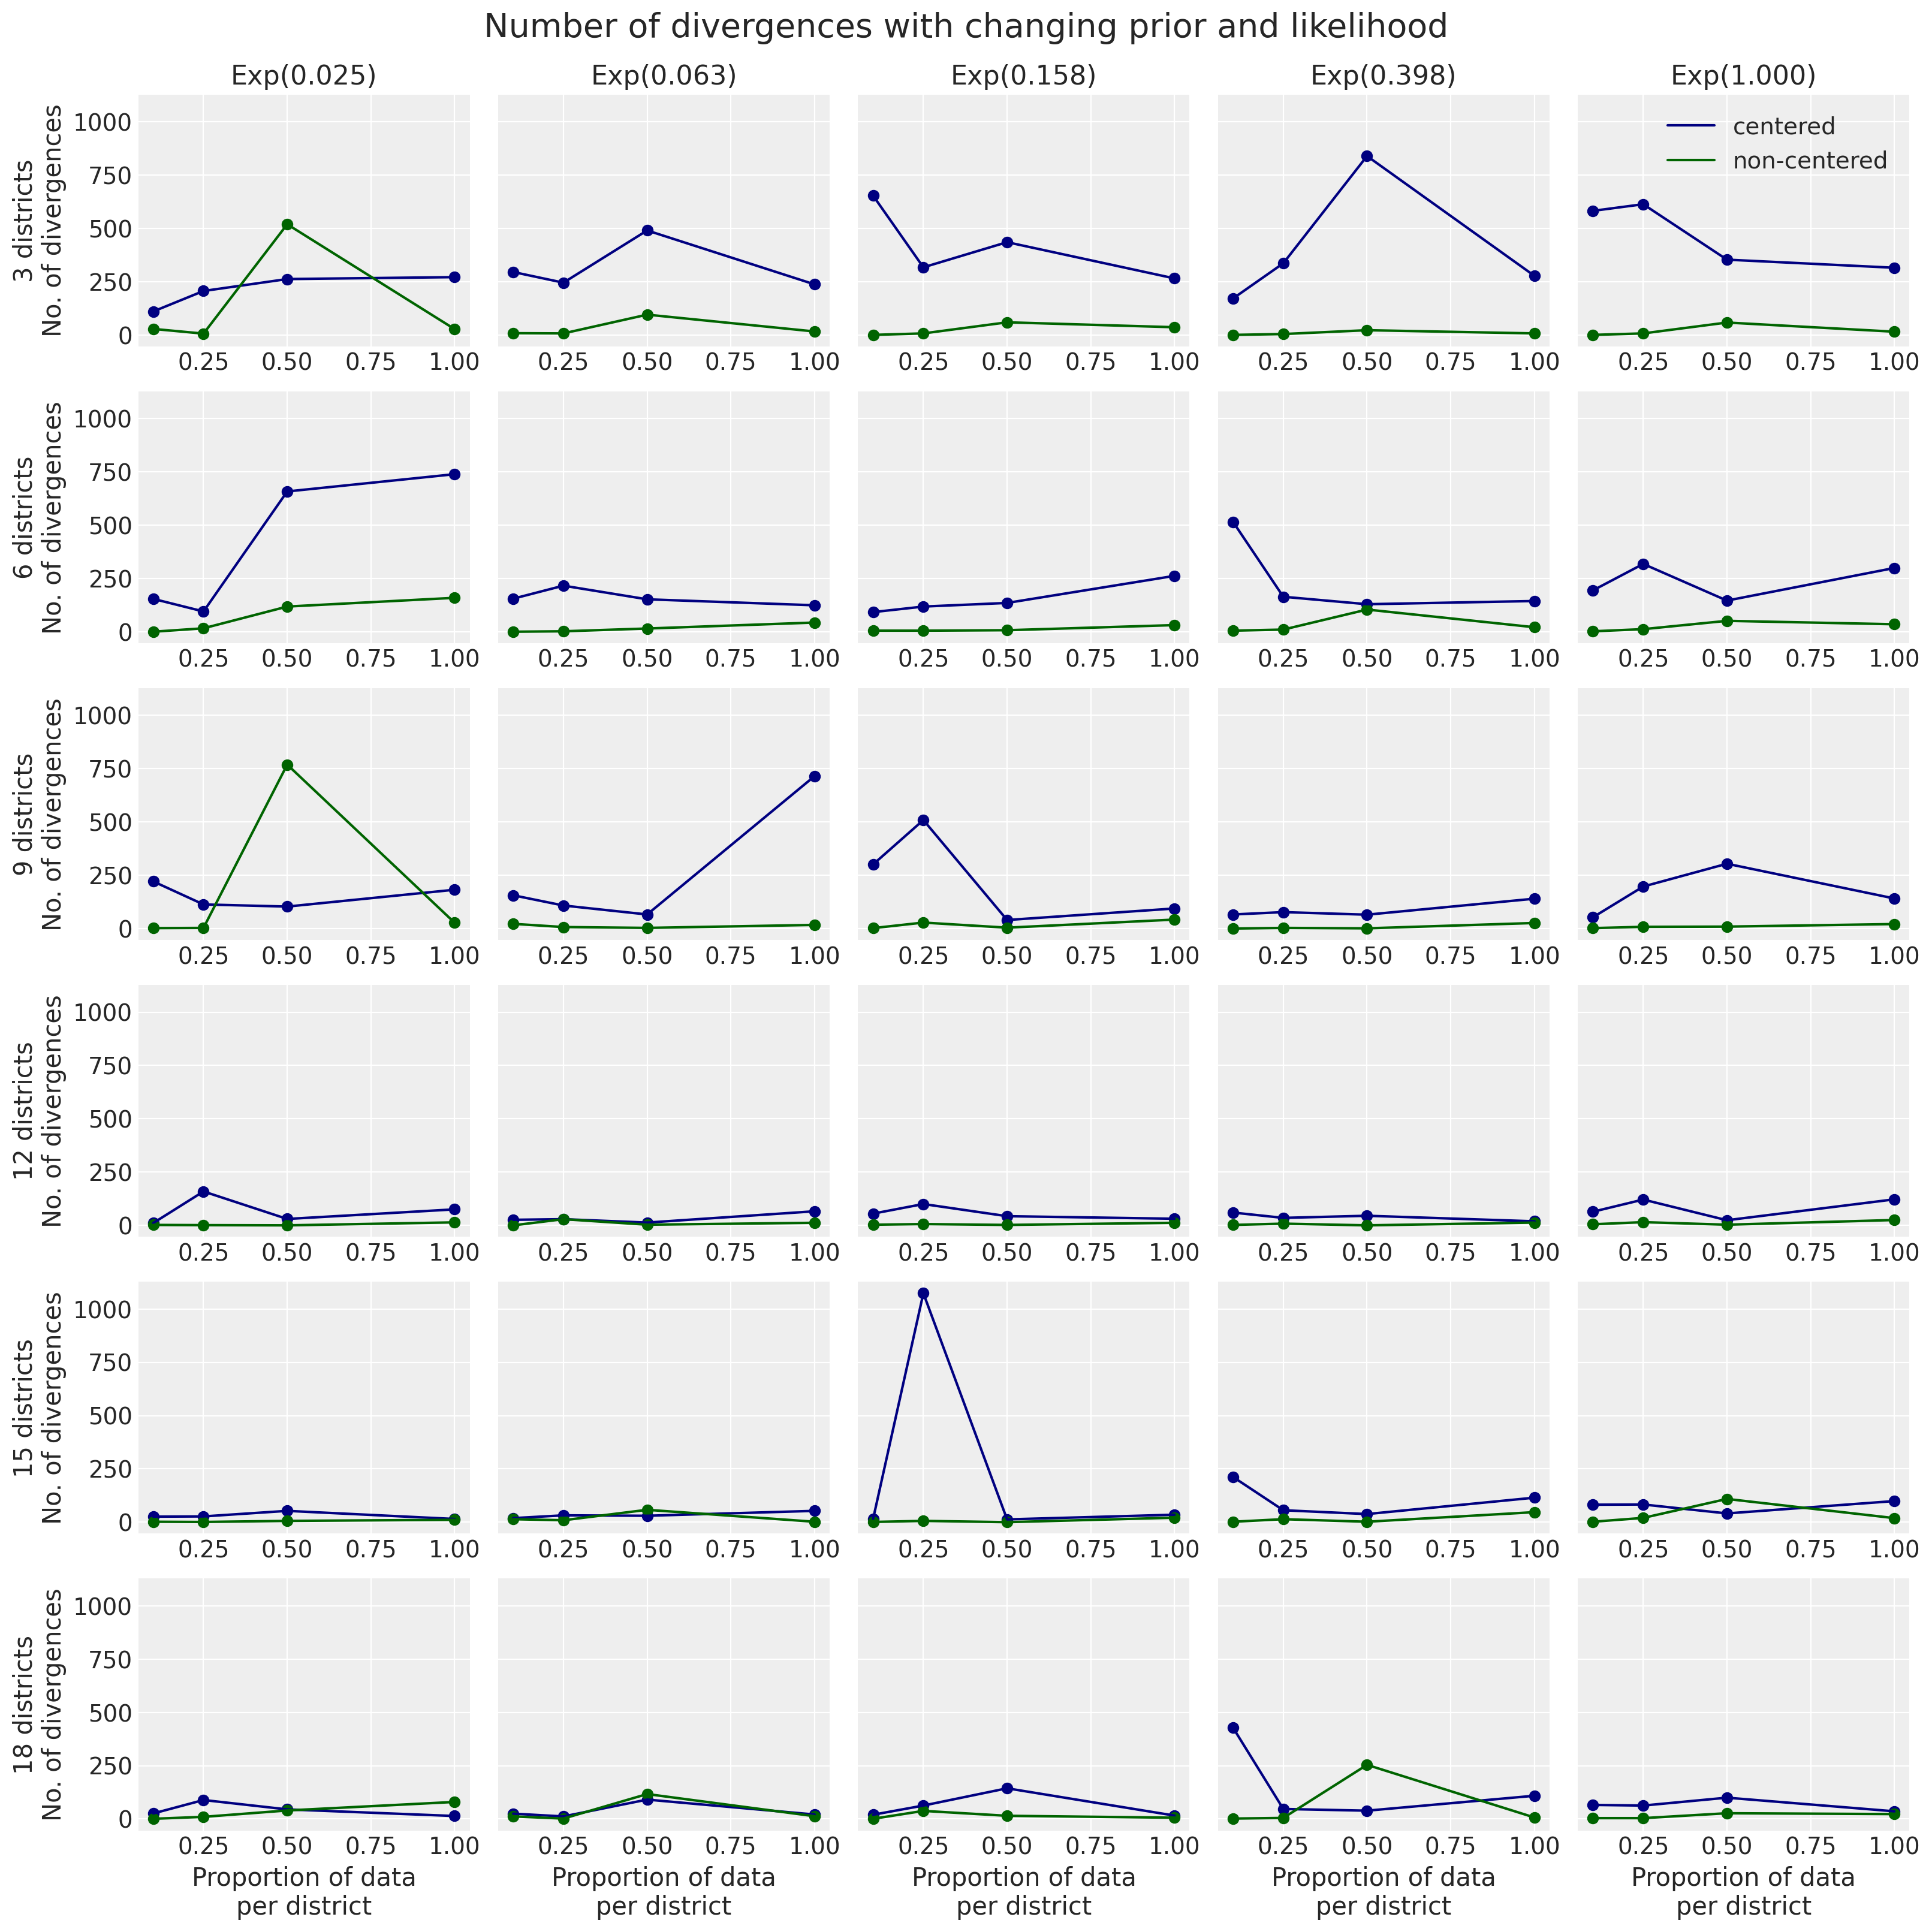

<IPython.core.display.Javascript object>

In [13]:
f, axes = plt.subplots(len(n_districts), len(sds), figsize=(16, 16), sharey=True)

i_dist = range(len(n_districts))
j_sds = range(len(sds))

for i in i_dist:

    n_dist = n_districts[i]
    df_div_Ci = df_div_C[df_div_C['n_districts'] == n_dist]
    df_div_NCi = df_div_NC[df_div_NC['n_districts'] == n_dist]

    for j in j_sds:

        sd = sds[j]
        # print(i, j)

        df_div_Cij = df_div_Ci[df_div_Ci['lamb'] == sd]
        df_div_NCij = df_div_NCi[df_div_NCi['lamb'] == sd]
        

        # Plot the divergences, centered
        ax = axes[i, j]
        ax.scatter(df_div_Cij['f_data'], df_div_Cij['n_div'], color='navy', )
        ax.plot(df_div_Cij['f_data'], df_div_Cij['n_div'], '-', color='navy', label='centered')

        # # Plot the divergences, non-centered
        ax.scatter(df_div_NCij['f_data'], df_div_NCij['n_div'], color='darkgreen')
        ax.plot(df_div_NCij['f_data'], df_div_NCij['n_div'], '-', color='darkgreen', label='non-centered')

        if (ax.is_last_col()) & (ax.is_first_row()):
            ax.legend()

        if ax.is_first_row():
            lamb = '{0:0.3f}'.format(sd)
            ax.set_title(f'Exp({lamb})')

        if ax.is_first_col():
            ax.set_ylabel(f'{n_dist} districts\nNo. of divergences')

        if ax.is_last_row():
            ax.set_xlabel('Proportion of data\nper district')

f.suptitle('Number of divergences with changing prior and likelihood', fontsize=20)


 Let me step through the whole figure and talk about how the different factors are tested before thinking about the results. When looking across the plots from left-to-right, the prior is more informative. In an exponential distribution, a higher value of lambda makes smaller values more likely. When looking from top to bottom, the number of clusters increases (top row is 3 districts, the bottom row is 18 districts.) And finally, within each plot, the amount of data within a district varies along the x-axis (e.g. the proportion of data).

 Taking all of this into account, along with the variability in each plot, it's not easy to see if a trend emerges. The top row (smallest number of clusters) shows that there are more divergences in the centered parameterization. This difference seems to get smaller with more clusters. But other than that, it's not easy to spot a trend.

## Number of effective samples

Text(0.5, 0.98, 'Effective sample size with changing prior and likelihood')

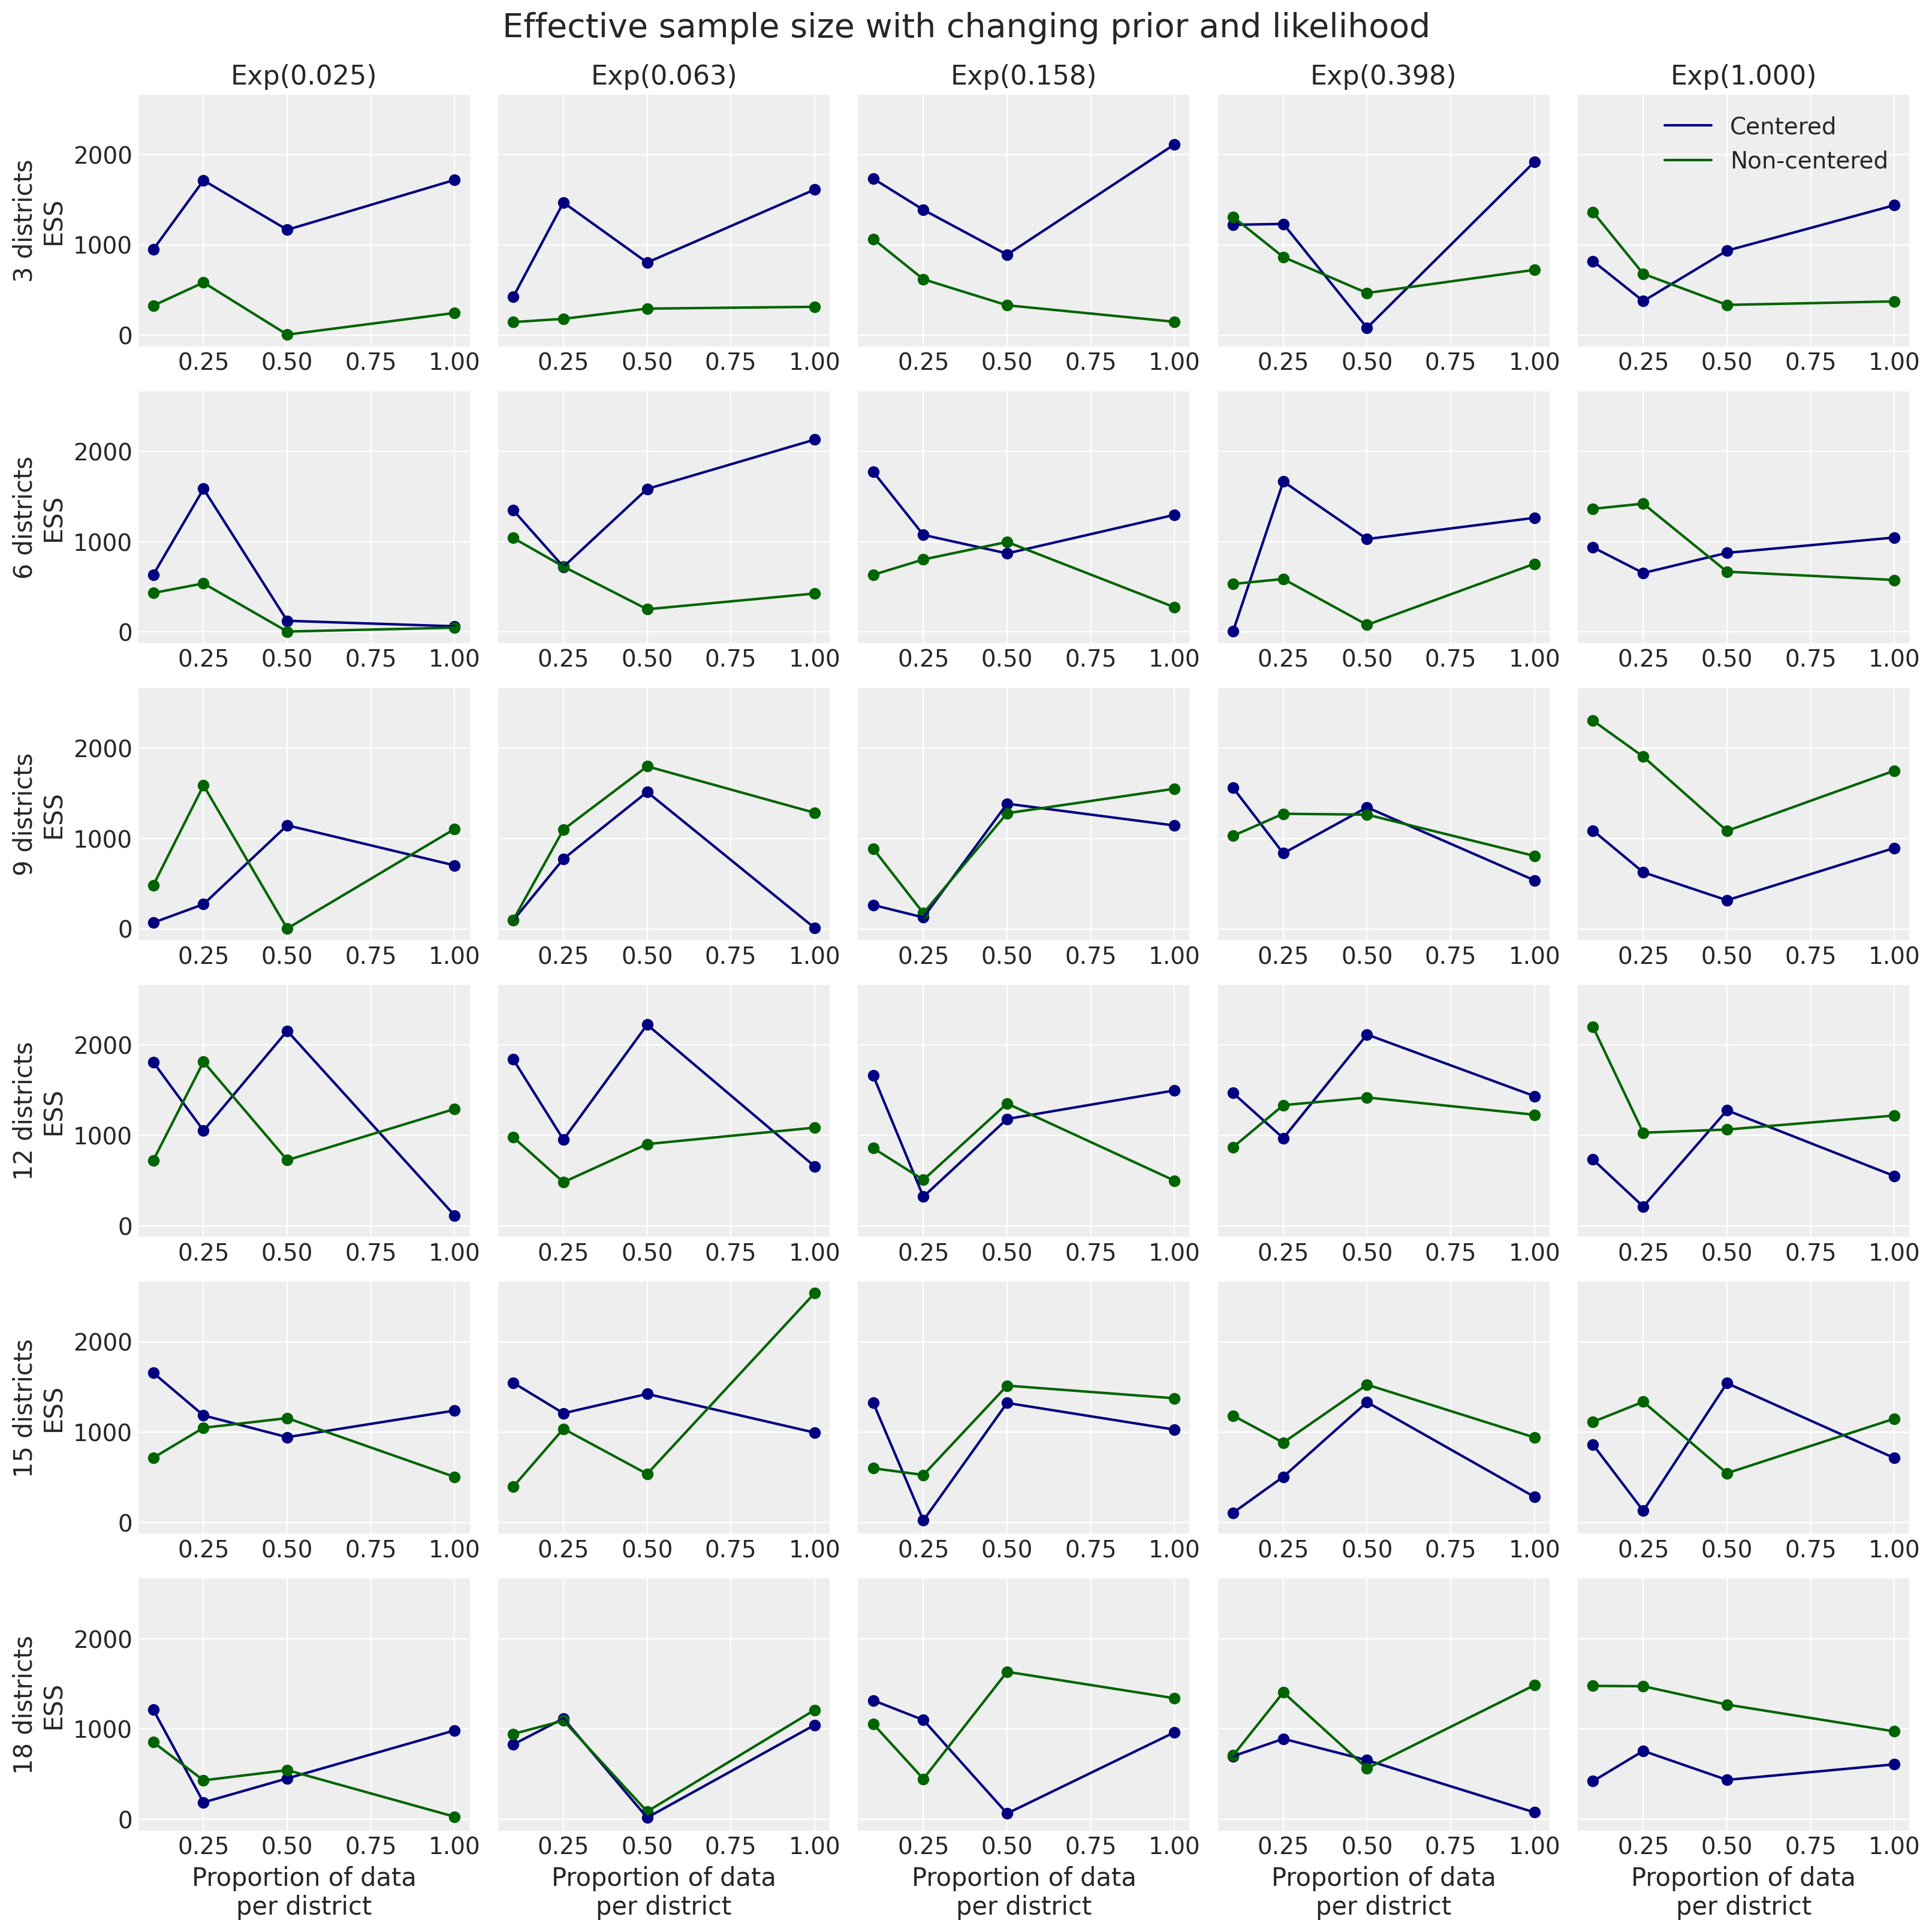

<IPython.core.display.Javascript object>

In [14]:
f, axes = plt.subplots(len(n_districts), len(sds), figsize=(16, 16), sharey=True)

i_dist = range(len(n_districts))
j_sds = range(len(sds))

for i in i_dist:

    n_dist = n_districts[i]
    df_summary_Ci = df_summary_C[df_summary_C['n_districts'] == n_dist]
    df_summary_NCi = df_summary_NC[df_summary_NC['n_districts'] == n_dist]

    for j in j_sds:

        sd = sds[j]
        df_summary_Cij = df_summary_Ci[df_summary_Ci['lamb'] == sd]
        df_summary_NCij = df_summary_NCi[df_summary_NCi['lamb'] == sd]

        # plot centered ESS
        df_centered_abar = df_summary_Cij.loc[df_summary_Cij['var']=='a_bar', :]
        df_noncentered_abar = df_summary_NCij.loc[df_summary_NCij['var']=='a_bar', :]

        ax = axes[i, j]
        ax.scatter(df_centered_abar['f_data'], df_centered_abar['ess_mean'], color='navy')
        ax.plot(df_centered_abar['f_data'], df_centered_abar['ess_mean'], color='navy', label='Centered')
        ax.scatter(df_noncentered_abar['f_data'], df_noncentered_abar['ess_mean'], color='darkgreen')
        ax.plot(df_noncentered_abar['f_data'], df_noncentered_abar['ess_mean'], color='darkgreen', label='Non-centered')

        if (ax.is_last_col()) & (ax.is_first_row()):
            ax.legend()

        if ax.is_first_row():
            lamb = '{0:0.3f}'.format(sd)
            ax.set_title(f'Exp({lamb})')

        if ax.is_first_col():
            ax.set_ylabel(f'{n_dist} districts\nESS')

        if ax.is_last_row():
            ax.set_xlabel('Proportion of data\nper district')

f.suptitle('Effective sample size with changing prior and likelihood', fontsize=20)

When now looking at the number of samples, we have the same ambiguity in trend... 
 Taking all of this into account, along with the variability in each plot, it's not easy to see if a trend emerges. The top row (smallest number of clusters) shows that there are more divergences in the centered parameterization. This difference seems to get smaller with more clusters. But other than that, it's not easy to spot a trend.

## R-hat

Text(0.5, 0.98, 'R-hat with changing prior and likelihood')

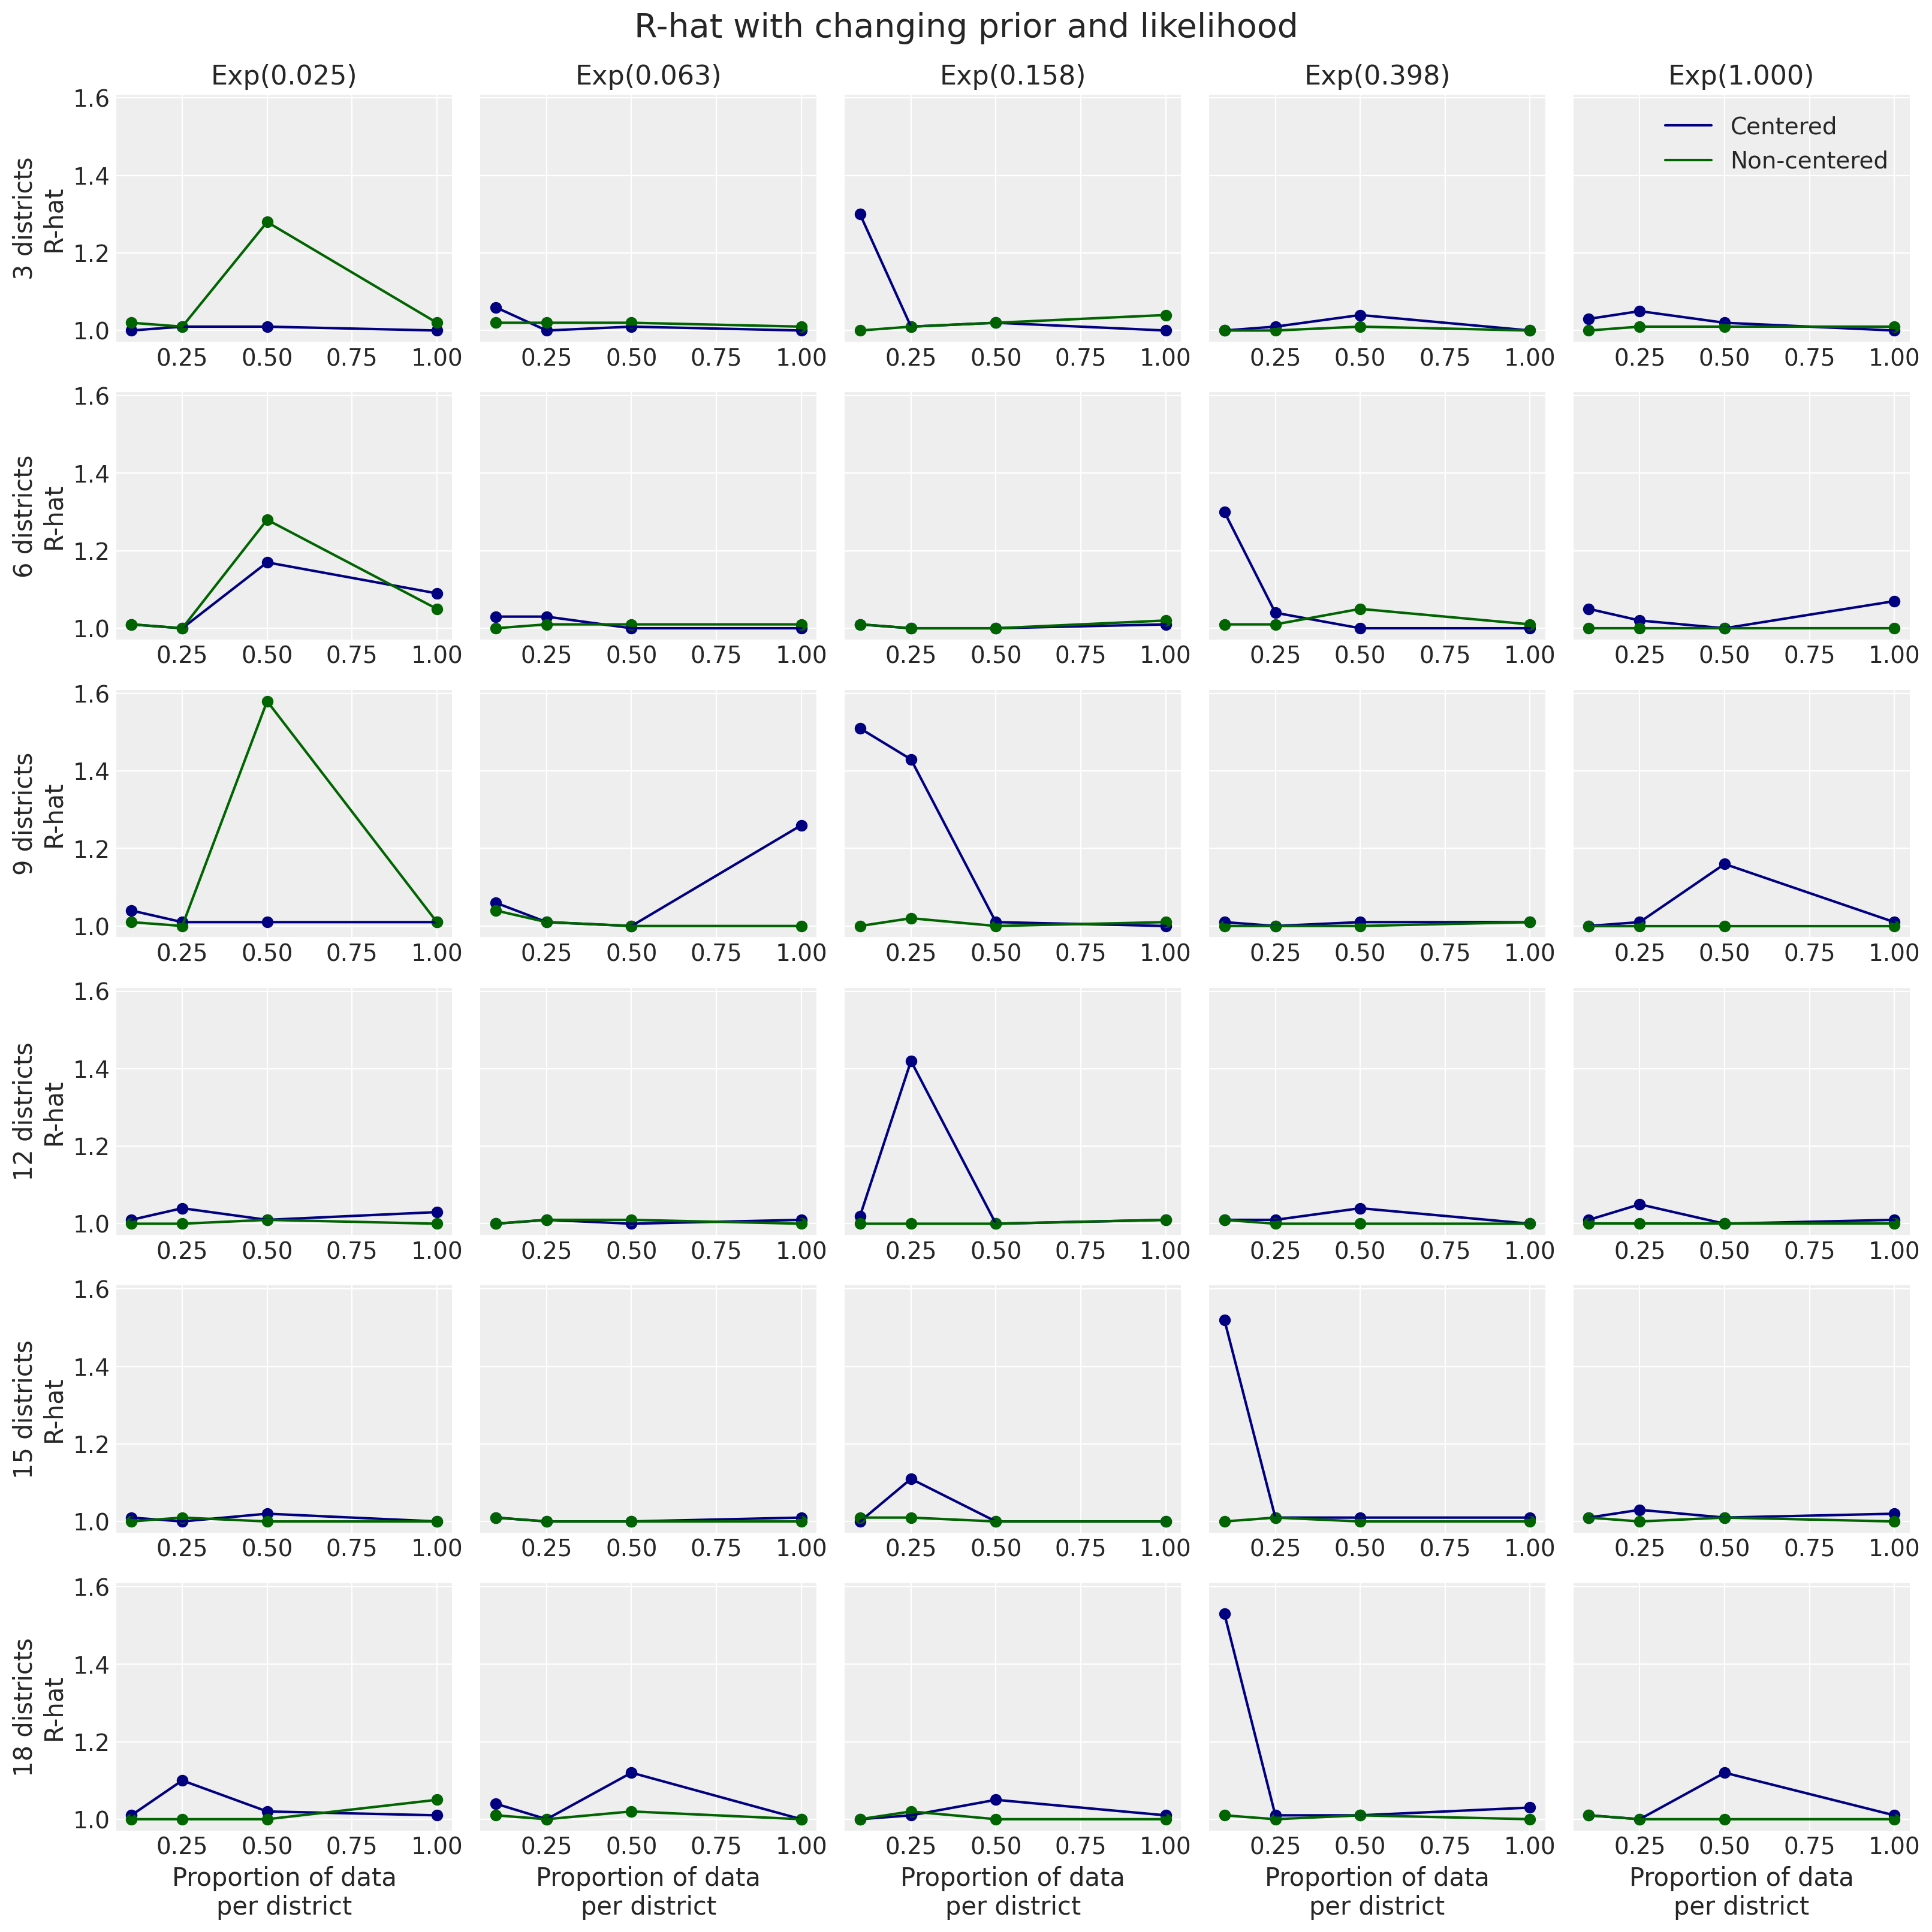

<IPython.core.display.Javascript object>

In [15]:
f, axes = plt.subplots(len(n_districts), len(sds), figsize=(16, 16), sharey=True)

i_dist = range(len(n_districts))
j_sds = range(len(sds))

for i in i_dist:

    n_dist = n_districts[i]
    df_summary_Ci = df_summary_C[df_summary_C['n_districts'] == n_dist]
    df_summary_NCi = df_summary_NC[df_summary_NC['n_districts'] == n_dist]

    for j in j_sds:

        sd = sds[j]
        df_summary_Cij = df_summary_Ci[df_summary_Ci['lamb'] == sd]
        df_summary_NCij = df_summary_NCi[df_summary_NCi['lamb'] == sd]

        # plot centered ESS
        df_centered_abar = df_summary_Cij.loc[df_summary_Cij['var']=='a_bar', :]
        df_noncentered_abar = df_summary_NCij.loc[df_summary_NCij['var']=='a_bar', :]

        ax = axes[i, j]
        ax.scatter(df_centered_abar['f_data'], df_centered_abar['r_hat'], color='navy')
        ax.plot(df_centered_abar['f_data'], df_centered_abar['r_hat'], color='navy', label='Centered')
        ax.scatter(df_noncentered_abar['f_data'], df_noncentered_abar['r_hat'], color='darkgreen')
        ax.plot(df_noncentered_abar['f_data'], df_noncentered_abar['r_hat'], color='darkgreen', label='Non-centered')


        if (ax.is_last_col()) & (ax.is_first_row()):
            ax.legend()

        if ax.is_first_row():
            lamb = '{0:0.3f}'.format(sd)
            ax.set_title(f'Exp({lamb})')

        if ax.is_first_col():
            ax.set_ylabel(f'{n_dist} districts\nR-hat')

        if ax.is_last_row():
            ax.set_xlabel('Proportion of data\nper district')

f.suptitle('R-hat with changing prior and likelihood', fontsize=20)

# Conclusion

If the biggest trick the devil pulled was convincing the world he didn't exist, then perhaps in this case the devil's funnel's trick was thinking that I could reason my way through understanding when centered and non-centered parameterizations would be better.

Appendix: Environment and system parameters

In [736]:
%watermark -n -u -v -iv -w

Last updated: Wed Feb 23 2022

Python implementation: CPython
Python version       : 3.8.6
IPython version      : 7.20.0

seaborn    : 0.11.1
matplotlib : 3.3.4
statsmodels: 0.12.2
sys        : 3.8.6 | packaged by conda-forge | (default, Jan 25 2021, 23:22:12) 
[Clang 11.0.1 ]
pandas     : 1.2.1
arviz      : 0.11.1
numpy      : 1.20.1
pymc3      : 3.11.0
scipy      : 1.6.0
daft       : 0.1.0

Watermark: 2.1.0



<IPython.core.display.Javascript object>